In [1]:
# Import necessary libraries
from torch.utils.data import DataLoader
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch


from torch import nn
from data import TimeFusionDataset
from timefusion import TimeFusion
from utils.metrics import variogram_score, crps_sum
from utils.modules import EarlyStopper

In [2]:
# Import dataset
train_data = pd.read_csv("../datasets/electricity/train.csv").set_index("date")
test_data = pd.read_csv("../datasets/electricity/test.csv").set_index("date")
train_data = train_data.iloc[:,:30]
test_data = test_data.iloc[:,:30]

full_data = pd.concat([train_data,test_data])
means = full_data.rolling(48,min_periods=48).mean()
norm_full_data = (full_data / means).to_numpy()
# TODO: Need to shift means so that they divide the one earlier

In [3]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
#elif torch.backends.mps.is_available():
#    device = torch.device("mps")
else:
    device = torch.device("cpu")

In [4]:
context_length = 48
prediction_length = 7*24

# Create each dataset
train_dataset = TimeFusionDataset(
    data = train_data.iloc[:int(0.9*len(train_data))],
    context_length = context_length,
)
train_dataset.add_timestamp_encodings()

val_dataset = TimeFusionDataset(
    data = train_data.iloc[int(0.9*len(train_data)):],
    context_length = context_length,
)
val_dataset.add_timestamp_encodings()

test_dataset = TimeFusionDataset(
    data = test_data,
    context_length = context_length,
)
test_dataset.add_timestamp_encodings()

train_loader = DataLoader(
    dataset = train_dataset,
    shuffle = True,
    num_workers = 4,
    batch_size = 128,
)

val_loader = DataLoader(
    dataset = val_dataset,
    shuffle = True,
    num_workers = 4,
    batch_size = 128,
)



In [5]:
predictor = TimeFusion(
    prediction_length = prediction_length,
    input_size = train_dataset.tensor_data.shape[1],
    output_size = len(train_dataset.ts_columns),
    hidden_size = 60,
    recurrent_layers = 2,
    dropout = 0.0,
    residual_layers = 2,
    scaling = True,
    device = device,
    scaler_kwargs = {"scaled_rows":list(range(30))}
)

print("Number of trainable parameters:",sum(p.numel() for p in predictor.parameters()))

Number of trainable parameters: 89094


/Users/edvard/Documents/Imperial College/Year 4/Final Year Project/Final-Year-Project/timefusion/diffusion.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.bar_alphas = torch.tensor(


In [6]:
# optimizer = torch.optim.Adam(params=predictor.parameters(),lr=5e-4)
# lr_scheduler = torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=1, end_factor=0.01, total_iters=40)

# predictor.train_network(
#     train_loader = train_loader,
#     epochs=40,
#     val_loader = val_loader,
#     val_metrics= {
#         "Val MAE": nn.L1Loss(),
#     },
#     optimizer = optimizer,
#     lr_scheduler= lr_scheduler,
#     early_stopper=EarlyStopper(patience=10),
#     save_weights = True,
#     weight_folder = "weights"
# )

In [7]:
# Loading weights
predictor.load_state_dict(torch.load("weights/2023-05-16-18-09-05"))
predictor.eval()

TimeFusion(
  (scaler): MeanScaler()
  (diff_embedding): DiffusionEmbedding(
    (projection1): Linear(in_features=32, out_features=32, bias=True)
    (tanh1): Tanh()
    (projection2): Linear(in_features=32, out_features=32, bias=True)
  )
  (rnn): LSTM(38, 60, num_layers=2, batch_first=True)
  (linear1): Linear(in_features=122, out_features=122, bias=True)
  (linear2): Linear(in_features=122, out_features=122, bias=True)
  (linear3): Linear(in_features=122, out_features=30, bias=True)
  (relu): ReLU()
)

In [8]:
x = []
y = []

i = 24*30+prediction_length + 300
while i < norm_full_data.shape[0]:

    x.append(norm_full_data[i-24*30-prediction_length:i-prediction_length])
    y.append(norm_full_data[i-prediction_length:i])

    i += 5

x2 = np.array(x)
y2 = np.array(y)

In [9]:
from sklearn.linear_model import LinearRegression

regs = []
for i in range(30):
    regs.append(LinearRegression().fit(x2[:,:,i], y2[:,:,i]))


Plots for idx: 0


/var/folders/wy/k9h01g4j2yg_jky8w6rsfsjm0000gn/T/ipykernel_27650/1061510086.py:9: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:233.)
  a = [torch.tensor([reg.predict([norm_full_data[idx + train_data.shape[0] - 24*30:idx + train_data.shape[0],i]])[0]]) for i,reg in enumerate(regs)]


Plots for idx: 50
Plots for idx: 100


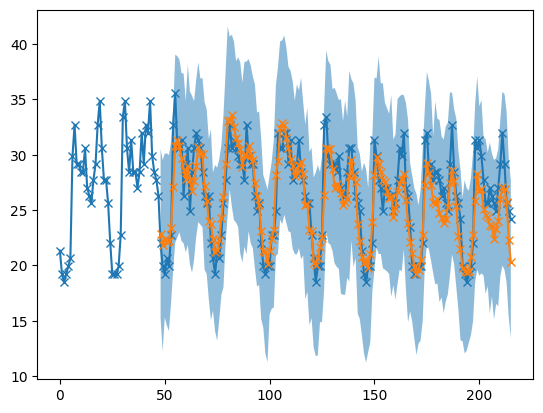

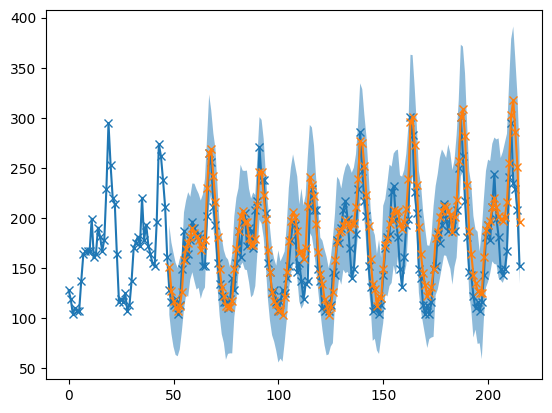

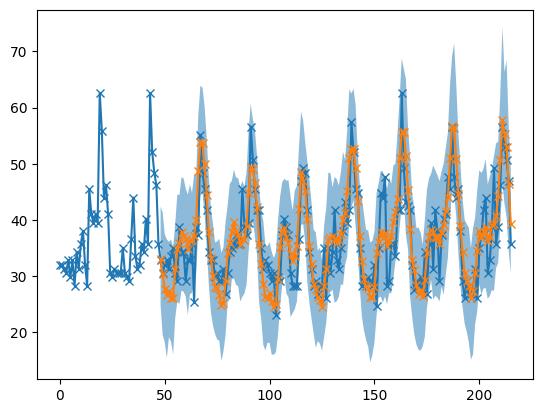

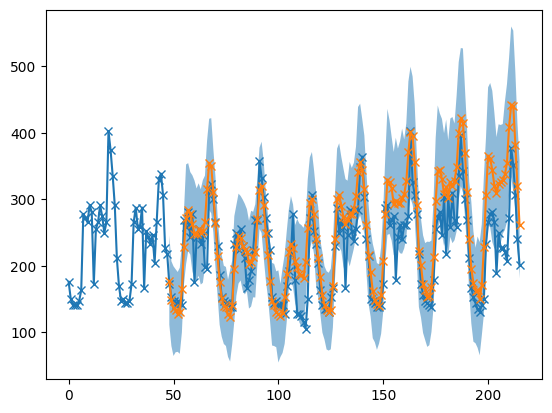

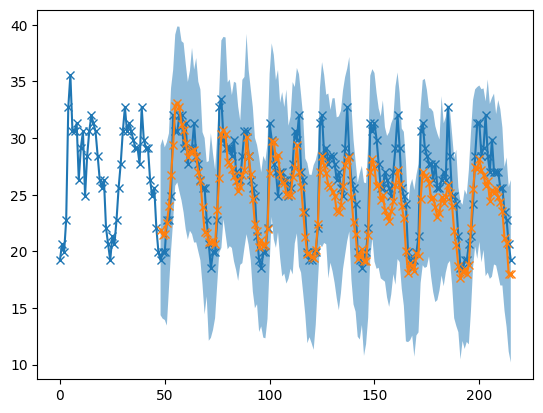

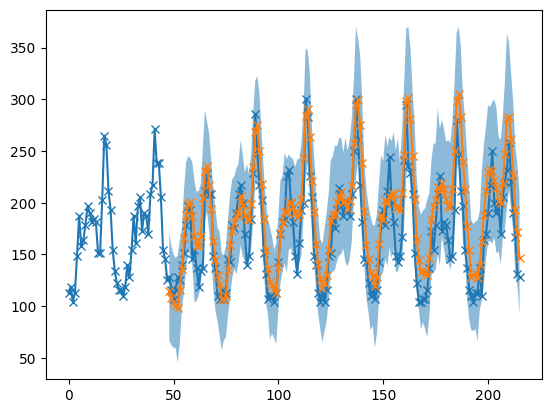

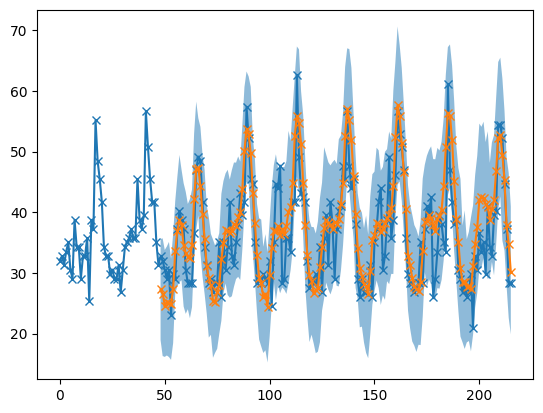

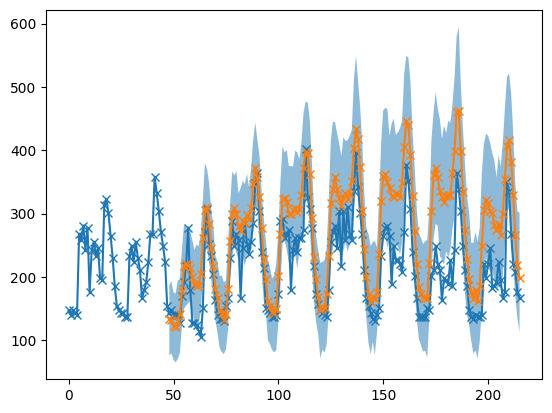

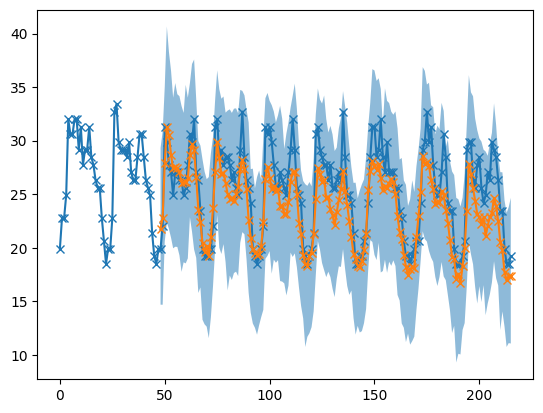

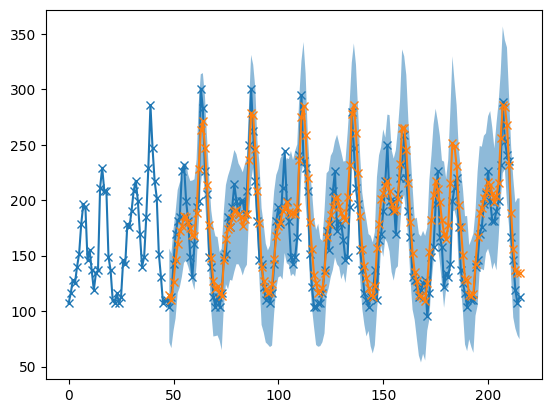

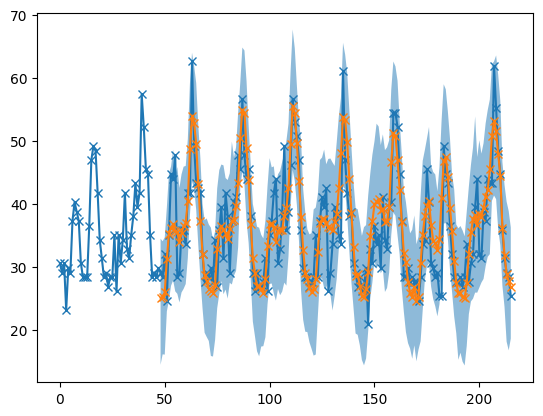

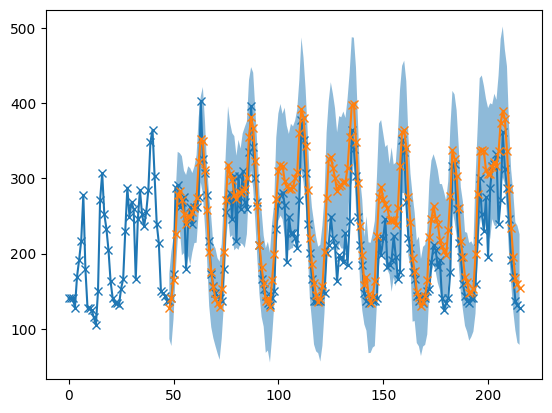

In [10]:
full_data_array = full_data.to_numpy()

idx = 0
for idx in {0,50,100}:
    print(f"Plots for idx: {idx}")

    historical_data = []
    for i in range(prediction_length):
        a = [torch.tensor([reg.predict([norm_full_data[idx + train_data.shape[0] - 24*30:idx + train_data.shape[0],i]])[0]]) for i,reg in enumerate(regs)]
        break
        #a = norm_full_data[(idx + train_data.shape[0]+i)%(1*24):idx + train_data.shape[0]:1*24]
        #a = a[~np.isnan(a).any(axis=1)]
        #a = full_data_array[(idx + train_data.shape[0]+i)%(7*24):idx + train_data.shape[0]:7*24]
        historical_data.append(a)
    
    historical_data = torch.tensor(np.array([reg.predict([norm_full_data[idx + train_data.shape[0] - 24*30:idx + train_data.shape[0],i]])[0] for i,reg in enumerate(regs)])).T

    samples = predictor.sample(
        data = test_dataset,
        idx = idx,
        num_samples = 128,
        batch_size = 128,
        historical_data=historical_data
    )

    confidence = 0.1
    samples_cpu = samples.cpu()
    for i in range(samples_cpu.shape[1]):
        samples_cpu[:,i,:], _ = torch.sort(samples_cpu[:,i,:], dim=0)

    for ts in [1,5,10,15]:
        plt.figure()
        plt.plot(list(range(context_length + prediction_length)),test_dataset.tensor_data[idx:idx+context_length+prediction_length,ts],"-x")
        plt.plot(list(range(context_length,context_length+prediction_length)),torch.mean(samples_cpu[:,ts],dim = 0),"-x")
        plt.fill_between(list(range(context_length,context_length+prediction_length)), samples_cpu[int(confidence*samples_cpu.shape[0]),ts], samples_cpu[int((1-confidence)*samples_cpu.shape[0]),ts],alpha=0.5)
        plt.savefig(f"images/original_{idx}_{ts}.png")

In [11]:
historical_data.shape

torch.Size([168, 30])

In [12]:
# Sample for first two weeks of test data
samples = []
for i in range(14):
    idx = 24*i

    # historical_data = []
    # for i in range(prediction_length):
    #     a = norm_full_data[(idx + train_data.shape[0]+i)%(1*24):idx + train_data.shape[0]:1*24]
    #     a = a[~np.isnan(a).any(axis=1)]
    #     historical_data.append(a)

    historical_data = torch.tensor([reg.predict([norm_full_data[idx + train_data.shape[0] - 24*30:idx + train_data.shape[0],i]])[0] for i,reg in enumerate(regs)]).T

    samples.append(
        predictor.sample(
            data = test_dataset,
            idx = idx,
            num_samples = 128,
            batch_size = 128,
            historical_data=historical_data
        ).cpu()
    )

samples = torch.cat([x.unsqueeze(0) for x in samples], dim = 0)

realisations = []
for i in range(14):
    idx = 24*i

    realisations.append(
        test_dataset.tensor_data[context_length + idx:idx + context_length + prediction_length,test_dataset.ts_columns].T
    )

realisations = torch.cat([x.unsqueeze(0) for x in realisations], dim = 0)

In [13]:
# Get numerical values for performance of network
from sklearn.metrics import mean_absolute_error, median_absolute_error, mean_squared_error

# MAE and MdAE of average prediction
mse = mean_squared_error(realisations.flatten(), torch.mean(samples,dim=1).flatten())
mae = mean_absolute_error(realisations.flatten(), torch.mean(samples,dim=1).flatten())
mdae = median_absolute_error(realisations.flatten(), torch.mean(samples,dim=1).flatten())
print(f"MSE: {mse}, MAE: {mae}, MDAE: {mdae}")


# Variogram and CRPS_SUM
var_score = np.mean([variogram_score(realisations[i].numpy(), samples[i].numpy(),**{"weights":"local","window_size":3}) for i in range(realisations.shape[0])])
crps_score = np.mean([crps_sum(realisations[i].numpy(), samples[i].numpy()) for i in range(realisations.shape[0])])

print("VAR:",var_score,"CRPS_sum:",crps_score)

MSE: 1388.3681640625, MAE: 17.680952072143555, MDAE: 6.2052412033081055


/Users/edvard/Documents/Imperial College/Year 4/Final Year Project/Final-Year-Project/timefusion/utils/metrics.py:64: IntegrationWarning: The maximum number of subdivisions (100) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  return integrate.quad(lambda y: (percentileofscore(F,y,kind="weak")/100 - np.heaviside(y - x, 1))**2, min(min(F),x), max(max(F),x),epsrel=1.49e-2,limit=100)
/Users/edvard/Documents/Imperial College/Year 4/Final Year Project/Final-Year-Project/timefusion/utils/metrics.py:64: IntegrationWarning: The maximum number of subdivisions (100) has been achieved.
  If increasing the limit yields no improvement it is advised to an

VAR: 864208.6538002596 CRPS_sum: 109.99779209023642


In [14]:
means = train_data.rolling(48,min_periods=48).mean()
norm_train_data = (train_data / means).dropna()

In [15]:
vals = []
for i in range(2,73): 
    k = norm_train_data.rolling(i,min_periods=i).apply(lambda x: abs(x[0] - x[-1])).dropna().sum()
    vals.append(k)
    print(i,k)

2 0     10818.993780
1      2079.342634
2      2555.013056
3      3441.336765
4      3259.050846
5      3176.058898
6      4915.862017
7      2643.766719
8      4753.513345
9      4465.275461
10     3173.106758
12     4427.596243
13     2594.407506
15     3457.043769
16     2801.471421
17     3468.552243
18     3975.982082
19     3197.640392
20     2845.750898
21     5446.588029
22     5328.146314
24     3898.511513
25     4182.254297
26     3755.305961
27     2748.353221
28     1948.475084
30     3189.215027
33     3408.000275
34     3591.037529
35     5468.203685
dtype: float64
3 0     12349.496613
1      3290.667682
2      3359.857889
3      5239.454802
4      4508.137666
5      4844.857615
6      6408.225730
7      3813.435899
8      6870.331538
9      6394.779321
10     4568.764505
12     6401.244842
13     4005.696618
15     5465.866916
16     4218.682666
17     5285.306247
18     5409.069032
19     4430.455940
20     4408.168267
21     7580.841613
22     8183.135385
24     5884.

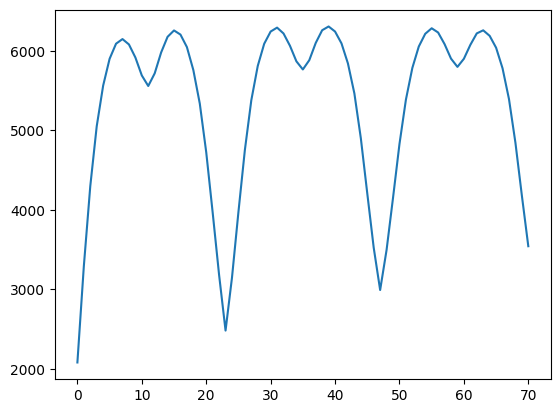

In [ ]:
plt.plot([i[1] for i in vals])

In [ ]:
import math
math.exp(-0.03*300)

train_array = train_data.to_numpy()

idx = 20000
x = []
for i in range(24):
    tmp = train_array[(idx+i)%24:idx:24]
    tmp2 = np.exp(-0.03*np.array(range(tmp.shape[0],0,-1)))
    tmp2 /= sum(tmp2)
    x.append(np.sum(tmp*np.expand_dims(tmp2,-1),0))
    
x = np.array(x)

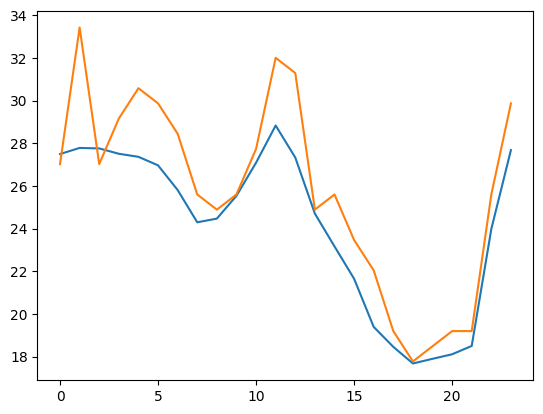

In [ ]:
plt.plot(x[:,1])
plt.plot(train_array[idx:idx+24,1])

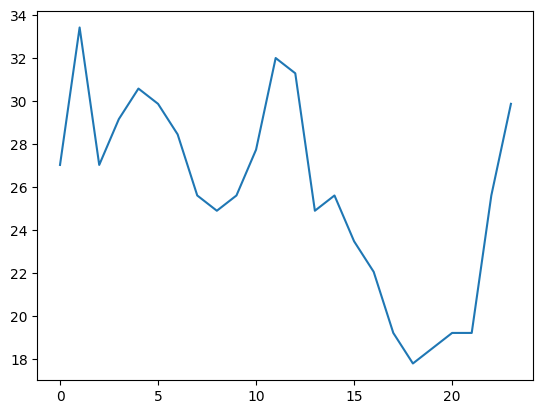

In [ ]:
plt.plot(train_array[idx:idx+24,1])

In [ ]:
x.sum(1).shape

(24, 30)

In [ ]:
np.array(x).shape

(24, 833, 30)

In [ ]:
train_array = train_data.to_numpy()

train_array[:100:24,0]

array([ 3.8071066 ,  3.8071066 ,  3.8071066 ,  5.07614213, 17.76649746])

In [ ]:
idx % 24

4

In [ ]:
train_data.shape

(24096, 30)